In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def create_graph(df) -> dict:
    """
    returns a didct with keys = node key, and values = edges (node_id, edge weight) 
    """
    tree = {}
    for _, row in df.iterrows():
        parent = row['Parent']
        child = row['Child']
        weight = row['t']

        # root node
        if pd.isna(parent): 
            continue
        # node already exists
        elif parent in tree: 
            tree[parent].append((child, weight))
        # node does not exists
        else:
            tree[parent] = [(child, weight)]
    return tree


def pd_z0():
    return max(np.random.normal(alpha_0, np.sqrt(variance_0)), 1)


def cpd(z, t):
    mean = gamma_0 + (alpha * t) + (beta * z) + (gamma * t * z)
    var = variance * t
    return max(np.random.normal(mean, np.sqrt(var)), 1)


def simulation(root: int, graph: dict, alpha0, variance0, alpha, beta, variance) -> dict:
    """
    BFS
    returns z value for all 407 nodes
    """
    gene_lengths = {}
    
    z0 = max(np.random.normal(alpha0, np.sqrt(variance0)), 1)
    queue = [(root, z0)]

    while queue:
        # handle the next element in queue
        node, z = queue.pop(0)
        
        # set node in results in genelength z
        gene_lengths[node] = z
        
        # get all children for the node
        children = graph.get(node, [])

        if not children:
            continue
        else:
            # for all the children for this node calculate their z
            # since we know it's a tree, only the parent can have influence
            for child in children:
                id, t = child
                t = round(t, 3)
                
                # draw a sample
                mean = (alpha * t) + (beta * z)
                var = variance * t
                
                    
                cpd_z = max(np.random.normal(mean, np.sqrt(var)), 1)
                #print(f"id:{id}, t:{t}, var:{var}, std:{np.sqrt(var)}, mean:{mean}, cpd:{cpd_z}")
                #if id == 205:
                #    print(var)
                #    print(mean)
                #    print(cpd_z)
                # append child to queue
                queue.append((id, cpd_z))

    return gene_lengths


def n_simulations(n, root, graph, alpha0, variance0, alpha, beta, variance) -> tuple:
    """
    Returns results for X=X1 ... X204 n times, and y=Z0 n times s
    """
    X = np.empty((n, 204))
    Z = np.empty((n, 203))
    y = np.empty(n)
    
    for i in range(n):
        if type(alpha0) == np.dtype('object_'): 
            results = simulation(root=root, graph=graph, alpha0=alpha0[i], variance0=variance0[i], alpha=alpha[i], beta=beta[i], variance=variance[i])
        else:
            results = simulation(root=root, graph=graph, alpha0=alpha0, variance0=variance0, alpha=alpha, beta=beta, variance=variance)
        # extract the first 204 values from the dictionary and add them to X as a row
        row_X = [results[key] for key in range(1, 205)]
        row_Z = [results[key] for key in range(205, 408)]
        
        X[i] = np.array(row_X)
        Z[i] = np.array(row_Z)
        
        
    return X, Z



def dfs_paths_with_cpd(graph, start_node, z, path=None):
    # returns all paths and the gene length at each node in the path
    if path is None:
        path = [(start_node, z)]

    if start_node not in graph:
        return [path]

    paths = []
    for child, t in graph[start_node]:
        if child not in [node for node, _ in path]:
            new_z = cpd(z, t)
            child_paths = dfs_paths_with_cpd(graph, child, new_z, path + [(child, new_z)])
            paths.extend(child_paths)

    return paths

In [3]:
# load data
tree_data = pd.read_csv('data/tree.csv')
genes_data = pd.read_csv('data/vert_genes.csv')

# remove root node, since we already have reference to it from else where. unless issue with t?
tree_data = tree_data[tree_data['Parent'].notna()]

# convert parent col to ints
tree_data['Parent'] = tree_data['Parent'].astype(int)

In [4]:
# gamma_0 + (alpha * time) (beta * parent gene len) + (gamma * time * parent gene len)

# Parameters
# for Z_0
alpha_0 = 50000
variance_0 = 5000

# for Z_i and X_i
alpha = 0.15
beta = 1.05
variance = 2500 

# Settings
root = 407
num_of_samples = 10000

# create a dict graph
graph = create_graph(tree_data)

In [5]:
# Create data
t0 = time.time()
X, Z = n_simulations(num_of_samples, root, graph, alpha_0, variance_0, alpha, beta, variance)
runtime = time.time() - t0
print(f"{runtime:.10f} sec")

11.8193299770 sec


In [6]:
y = Z[:,-1]

In [7]:
print(X.shape)
print(y.shape)

(10000, 204)
(10000,)


In [8]:
# lin reg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LinearRegression().fit(X_train, y_train)

# Train results
yt_pred = reg.predict(X_train)
train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, yt_pred)

# Test results
y_pred = reg.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"TRAIN. r2: {train_r2:.3f}, MSE: {train_mse:.3f}")
print(f"TEST. r2: {test_r2:.3f}, MSE: {test_mse:.3f}")

TRAIN. r2: 0.355, MSE: 3226.791
TEST. r2: 0.307, MSE: 3496.961


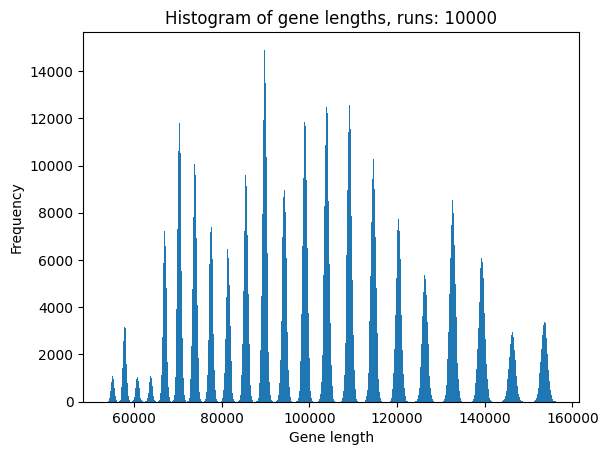

In [9]:
plt.hist(X.flatten(), bins=int(num_of_samples/10))

plt.xlabel('Gene length')
plt.ylabel('Frequency')
plt.title(f'Histogram of gene lengths, runs: {num_of_samples}')
plt.show()

In [11]:
# all paths with their respective z values at each node in the path
paths_with_z = dfs_paths_with_cpd(graph=graph, start_node=407, z=pd_z0())

# plot development of gene length for all paths
# longest = max(paths_with_z, key=len)  # plot the path with the most ancestors
for index, path in enumerate(paths_with_z):
    ys = [y[1] for y in path]
    plt.scatter(range(len(ys)), ys)

plt.xlabel('number of ancestors at node')
plt.ylabel('gene lengths')
plt.title('Development of gene length over ancestor nodes')
plt.show()

NameError: name 'gamma_0' is not defined

In [ ]:
# load data
treedat = pd.read_csv('data/tree.csv')
genesdat = pd.read_csv('data/vert_genes.csv')

In [ ]:
# 205 from the nan present
len(treedat['species'].unique())

205

In [ ]:
len(genesdat['species'].unique())

204

In [ ]:
len(genesdat['orthId'].unique())

10

In [ ]:
# group species by the orthid
grouped = genesdat.groupby('orthId')['species'].agg(list).reset_index()
grouped['species'][4] == grouped['species'][2]

False

In [ ]:
grouped['species'][0]  # gene 0

['Acanthisitta_chloris',
 'Anas_platyrhynchos',
 'Anser_cygnoides',
 'Apaloderma_vittatum',
 'Aptenodytes_forsteri',
 'Apteryx_australis',
 'Aquila_chrysaetos',
 'Balearica_regulorum',
 'Buceros_rhinoceros',
 'Calidris_pugnax',
 'Calypte_anna',
 'Caprimulgus_carolinensis',
 'Cariama_cristata',
 'Chaetura_pelagica',
 'Charadrius_vociferus',
 'Chlamydotis_macqueenii',
 'Colius_striatus',
 'Columba_livia',
 'Corvus_brachyrhynchos',
 'Corvus_cornix',
 'Coturnix_japonica',
 'Cuculus_canorus',
 'Egretta_garzetta',
 'Eurypyga_helias',
 'Falco_cherrug',
 'Falco_peregrinus',
 'Ficedula_albicollis',
 'Fulmarus_glacialis',
 'Gallus_gallus',
 'Gavia_stellata',
 'Geospiza_fortis',
 'Haliaeetus_albicilla',
 'Haliaeetus_leucocephalus',
 'Lepidothrix_coronata',
 'Leptosomus_discolor',
 'Meleagris_gallopavo',
 'Melopsittacus_undulatus',
 'Merops_nubicus',
 'Mesitornis_unicolor',
 'Nestor_notabilis',
 'Nipponia_nippon',
 'Opisthocomus_hoazin',
 'Parus_major',
 'Pelecanus_crispus',
 'Phaethon_lepturus',


PART 2

In [ ]:
# load data
tree_data = pd.read_csv('data/tree.csv')
genes_data = pd.read_csv('data/vert_genes.csv')

print(tree_data)
print(genes_data)


     Parent  Child     age_ch          t                 species
0     222.0      1   0.000000   9.000250  Peromyscus_maniculatus
1     222.0      2   0.000000   9.000250            Mus_musculus
2     221.0      3   0.000000  12.172706      Cricetulus_griseus
3     220.0      4   0.000000  14.684269       Rattus_norvegicus
4     219.0      5   0.000000  17.062881    Mesocricetus_auratus
..      ...    ...        ...        ...                     ...
402   399.0    403   7.861905   1.640772                     NaN
403   403.0    404   5.750020   2.111885                     NaN
404   404.0    405   5.500000   0.250020                     NaN
405   403.0    406   5.000000   2.861905                     NaN
406     NaN    407  50.024697   2.091292                     NaN

[407 rows x 5 columns]
        ensembl_id orthId  glength                       species
0     XP_009078534  1CPN2    66213          Acanthisitta_chloris
1     XP_005013863  1CPN2    44913            Anas_platyrhynchos
2

In [ ]:
class Node:
    def __init__(self,data):
        self.l = None
        self.r = None
        self.data = data
        

In [ ]:
def create_tree(root):
    children = tree_data[tree_data['Parent']==root]
    node = Node(tree_data[tree_data['Child']==root])
    if len(children)>0:
        for i in range(0, len(children)):
            if i == 0:
                node.l = create_tree(children.iloc[1].iloc[1])
            else:
                node.r = create_tree(children.iloc[0].iloc[1])
        return node
    else:
        return node

In [ ]:
# gamma_0 + (alpha * time) (beta * parent gene len) + (gamma * time * parent gene len)

# Parameters
# for Z_0
alpha_0 = 50000
variance_0 = 5000

# for Z_i and X_i
alpha = 0
beta = 1.01
variance = 2500 

In [ ]:
tree = create_tree(407)

mean = np.zeros(407)
covariance = np.array(407*[np.zeros(407)])

mean[406] = alpha_0
covariance[406,406] = variance_0

def meanCovariance(tree, mean, covariance):
    if tree != None:
        index = int(tree.data.iloc[0].iloc[1])
        t = int(tree.data.iloc[0].iloc[3])
        parent = int(tree.data.iloc[0].iloc[0])
        mean[index-1] = mean[parent-1]*beta+alpha*t

        covariance[index-1,:] = covariance[parent-1,:]*beta 
        covariance[:,index-1] = covariance[parent-1,:]*beta 

        covariance[index-1,index-1] = variance*t+beta*covariance[parent-1,parent-1]
        '''covariance[index-1,parent-1] = beta**2*covariance[parent-1,parent-1]
        covariance[parent-1,index-1] = beta**2*covariance[parent-1,parent-1]'''
        meanCovariance(tree.l,mean,covariance)
        meanCovariance(tree.r,mean,covariance)
    else:
        return

meanCovariance(tree.l,mean,covariance)
meanCovariance(tree.r,mean,covariance)

print(covariance)
print(mean)


[[121595.59978422 100086.55578206  92435.80578206 ...   6412.15997509
    6348.67324266   5980.73737843]
 [100086.55578206 121595.59978422  92435.80578206 ...   6412.15997509
    6348.67324266   5980.73737843]
 [ 92435.80578206  92435.80578206 120614.4552319  ...   6348.67324266
    6285.81509174   5921.52215686]
 ...
 [  6412.15997509   6412.15997509   6348.67324266 ... 115331.12154579
  111383.93276125   5360.67676054]
 [  6348.67324266   6348.67324266   6285.81509174 ... 111383.93276125
  114189.22925326   5307.60075301]
 [  5980.73737843   5980.73737843   5921.52215686 ...   5360.67676054
    5307.60075301   5000.        ]]
[59807.37378433 59807.37378433 59215.22156865 58628.93224618
 58048.4477685  57473.71066188 56904.66402166 56341.2515066
 55783.41733327 56341.2515066  56341.2515066  56904.66402166
 56904.66402166 56341.2515066  54684.26363422 62858.15091742
 62858.15091742 62235.79298755 61619.59701737 61009.5019974
 61009.5019974  61009.5019974  60405.44752218 60405.44752218


In [ ]:
#fik lige en bug her så det er kommenteret ud, men bruger det heller ikke lige pt. skal dog bruge det til message passing
J = np.linalg.inv(covariance)
h = np.matmul(J,mean)
print(J)
print(h)

[[ 4.64920710e-05 -2.33739621e-19  7.01920730e-20 ... -1.78067566e-19
  -6.65134968e-20  2.92464515e-19]
 [-2.01225603e-19  4.64920710e-05  8.77683511e-20 ... -2.07435410e-19
  -6.64371181e-20  2.95100237e-19]
 [ 5.10325830e-20  7.36815600e-20  3.43715188e-05 ...  7.04905756e-20
   3.08406824e-20 -1.28709976e-19]
 ...
 [-2.97261783e-19 -2.84134784e-19  1.17358896e-20 ... -6.87079945e-04
   3.27494250e-18 -2.35394319e-19]
 [-8.85549506e-20 -8.34333982e-20  4.49039727e-20 ...  2.49968856e-18
   4.35684071e-04  2.65622469e-19]
 [ 1.99305198e-20  2.06656620e-20 -1.11659921e-19 ... -7.70817864e-19
  -4.19981656e-19  7.53387702e-04]]
[ 5.98822038e-15 -7.64869552e-15  5.34129084e-14 -5.90906570e-15
 -1.73680612e-14  1.19504466e-14 -3.45948896e-14 -1.68818138e-14
  1.39268317e-14 -1.17416715e-14 -5.51267033e-15 -1.61917615e-14
  1.67961290e-14 -2.11021408e-15  4.48666562e-15  1.35625577e-15
  2.96984856e-14  2.31407971e-14 -2.16064628e-14 -2.86372715e-14
  2.05963217e-15  4.43381300e-15  2.883

In [ ]:
#load gene data og få lagt det ind i arrays, hvis et gene ikke er der sættes dens længde til 0.
a = np.array(10*[np.zeros(204)])
unique_genes = genes_data.loc[:,'orthId'].unique()

for i in range(0,204):
    species = tree_data.iloc[i].iloc[4]
    extract = genes_data[genes_data['species']==species]
    for j in range(0,10):
        temp = extract[extract['orthId']==unique_genes[j]]
        if len(temp)==1:
            a[j,i] = temp['glength']

print(a)
print(a.shape)

[[ 88338. 219992.  89972. ...   4568.   4239.  66937.]
 [ 30935.  31081.  40971. ...  34954.  33799.  31589.]
 [ 21555.  20662.  12707. ...   8561.   8475.      0.]
 ...
 [ 19977.  21211.  24187. ...   3964.      0.      0.]
 [ 16494.  15176.  16651. ...   7387.  19106.  18206.]
 [ 29924.   8341.   6260. ...   1881.   1852.   1778.]]
(10, 204)


In [ ]:
#estimere P(Z_i|x_1,..,x_204) og print normalfordelingen med (mean,variance)
for j in range(204,407):
    sigmaYX = covariance[j,:204]
    sigmaXY = covariance[:204,j]
    sigmaXX = np.linalg.inv(covariance[:204,:204])
    meanY = mean[j]+np.matmul(np.matmul(sigmaYX,sigmaXX),a[0]-mean[:204])
    covarianceY = covariance[j,j]-np.matmul(np.matmul(sigmaYX,sigmaXX),sigmaXY)
    print((meanY,covarianceY))


(55855.44083256449, 4739.783608097448)
(78571.6358560273, 6588.071921140512)
(94060.65425001882, 7191.183045022466)
(113446.4856838828, 6859.007831012885)
(120050.75025388118, 6733.8709217388205)
(135253.87869358005, 6837.4323311537955)
(158346.67141844414, 6161.051584664401)
(179264.56402163228, 4477.8786511554645)
(185618.21239137306, 5626.133194056871)
(191059.18405125308, 5950.24582876535)
(197631.70954943693, 6452.394290318487)
(202572.34708874178, 6411.280454915352)
(203965.70155786895, 6457.280614524614)
(200923.60303065926, 6490.103052443315)
(196287.59715782164, 6364.672794953163)
(186451.5284727686, 6201.9533516114025)
(171341.24780549237, 6242.841753238623)
(165198.87364728155, 6466.983357555568)
(227325.25242302168, 4128.01598026196)
(228655.51442179014, 3903.376780466715)
(233063.90082893765, 2695.1149159861816)
(237169.4067268092, 2882.25650703907)
(179655.67427869525, 4557.617692734049)
(183064.47546943516, 4827.5493512269095)
(190509.61109290598, 5482.802528045664)
(193

Part 3

In [12]:
# gamma_0 + (alpha * time) (beta * parent gene len) + (gamma * time * parent gene len)

# Parameters
# for Z_0
size = 5000
alpha0 = np.random.normal(50000, 50, size=size)
variance0 = np.random.normal(5000, 10, size=size)

# for Z_i and X_i
alpha = np.random.normal(0, 0.5, size=size)
beta = np.random.normal(3, 1, size=size)
variance = np.random.normal(2500, 10, size=size)

# Settings
root = 407

# create a dict graphe
graph = create_graph(tree_data)

In [13]:
print(alpha0.shape)
print(variance)
np.min(variance),np.max(variance),np.mean(variance),np.var(variance)

(5000,)
[2501.78535254 2509.38206149 2512.43429177 ... 2484.78413966 2507.75279039
 2500.76242308]


(2462.2317356742556, 2533.722193621766, 2500.163821353821, 97.77753472743068)

In [14]:
# Create data
t0 = time.time()

X, Z = n_simulations(size, root, graph, alpha0, variance0, alpha, beta, variance)
runtime = time.time() - t0
print(f"{runtime:.10f} sec")

7.0093719959 sec


In [15]:
V = np.concatenate((X,Z),axis=1)
train_size = int(size*4/5)



In [16]:
# lin r
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regAlpha = LinearRegression().fit(V[:train_size,:], alpha[:train_size])
regBeta = LinearRegression().fit(V[:train_size,:], beta[:train_size])
regVariance = LinearRegression().fit(V[:train_size,:], variance[:train_size])

# Train results
yt_pred = regAlpha.predict(V[train_size:,:])
test_r2 = regAlpha.score(V[train_size:,:], alpha[train_size:])
test_mse = mean_squared_error(alpha[train_size:], yt_pred)

yt_pred1 = regBeta.predict(V[train_size:,:]) #beta pred
yt_pred2 = regVariance.predict(V[train_size:,:]) #var pred


print(f"TEST. r2: {test_r2:.3f}, MSE: {test_mse:.3f}") #test alpha & beta
#print(f"TEST. r2: {test_r2:.3f}, MSE: {test_mse:.3f}")

TEST. r2: -0.000, MSE: 0.242


In [17]:
print(regBeta.score(V[train_size:,:],beta[train_size:]))
print(regVariance.score(V[train_size:,:],variance[train_size:]))
#print((yt_pred1,beta[train_size:]))
print((yt_pred2,variance[train_size:]))

print(regVariance.score(V[:train_size,:],variance[:train_size]))


0.9672474134572254
-0.007314438034981441
(array([2500.32883437, 2499.31513238, 2500.3105079 , 2500.54324812,
       2498.24520653, 2502.44924163, 2502.8354444 , 2499.93492838,
       2500.04186359, 2499.41062388, 2500.14857273, 2500.10455486,
       2500.65697933, 2500.25959263, 2500.41226133, 2500.25518608,
       2500.22526543, 2500.36010572, 2500.46185894, 2500.07217925,
       2500.29129009, 2500.4167875 , 2499.89874883, 2498.91178523,
       2499.26660335, 2500.00655884, 2500.11821723, 2500.3818458 ,
       2500.11669856, 2500.69535607, 2500.43952088, 2499.76615415,
       2499.89544061, 2500.57442662, 2500.71844393, 2499.98245887,
       2500.60433152, 2499.99981094, 2500.79054409, 2500.50515115,
       2500.50110354, 2499.76974454, 2499.85614888, 2500.22771702,
       2499.68163875, 2499.83059355, 2499.79007395, 2500.3447901 ,
       2499.66259188, 2500.21550313, 2500.27403602, 2500.0944471 ,
       2497.58290054, 2500.30219583, 2497.38727563, 2501.88207109,
       2500.48112763